# Aridity Refinement for Africa: Data Preparation and Processing

This notebook processes global aridity raster data and African boundaries to generate refined aridity region datasets for Sub-Saharan Africa. The workflow includes:

1. Trimming the global aridity raster to Africa's extent
2. Extracting the continent outline from boundaries
3. Further trimming the raster using the continent outline
4. Converting raster data to shapefiles for different aridity classes
5. Creating country-level arid region shapefiles for Sub-Saharan Africa


In [ ]:

# Import necessary libraries and utility functions
import sys
import os
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask as rio_mask
from rasterio.features import shapes
from shapely.geometry import mapping, box, shape
import matplotlib.pyplot as plt


# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path, ssa_iso
from Code.utils.spatial_utility import load_and_reproject


# Load configuration
config = load_config()

## 1. Trim Raster to a Reasonable Size

Original CRS: EPSG:4326
Clipped raster saved successfully.


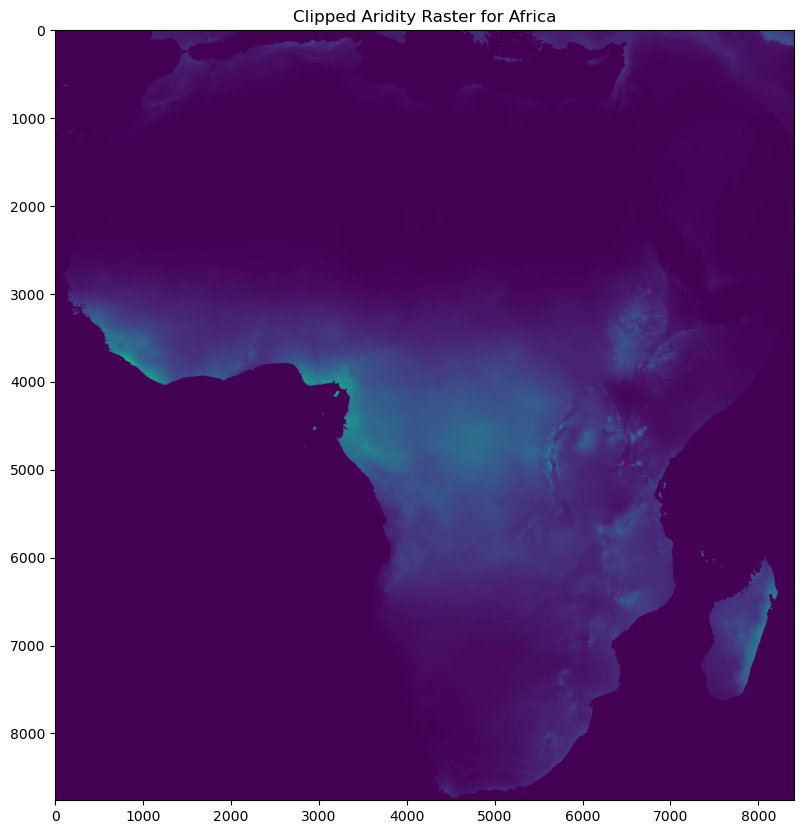

In [3]:

# Load the raster file and define the bounding box for Africa
with rasterio.open(resolve_path(config['Global_Aridity_Raster_path'])) as src:
    print(f"Original CRS: {src.crs}")

    # Define the bounding box for Africa (in degrees)
    bbox = box(-18.0, -35.0, 52.0, 38.0)  # Approximate coordinates for Africa
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs=src.crs)

    # Clip the raster to the bounding box
    out_image, out_transform = rio_mask(src, bbox_gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Save the clipped raster
    clipped_tif_path = resolve_path(config['Africa_Arid_Regions_tif_path'])
    with rasterio.open(clipped_tif_path, "w", **out_meta) as dest:
        dest.write(out_image)

    print("Clipped raster saved successfully.")

# Visualize the clipped raster
with rasterio.open(clipped_tif_path) as src:
    plt.figure(figsize=(10, 10))
    plt.imshow(src.read(1), cmap='viridis')
    plt.title("Clipped Aridity Raster for Africa")
    plt.show()

## 2. Get Continent Outline from Africa Boundaries

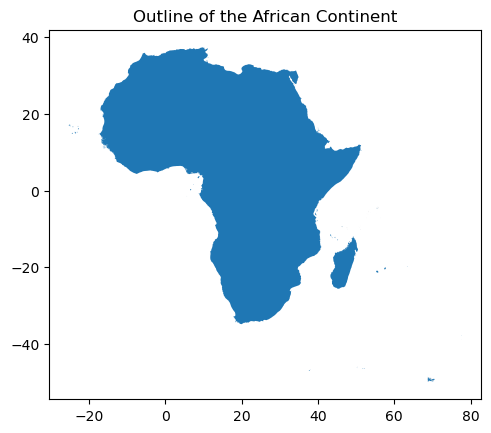

In [3]:
# Load and dissolve Africa boundaries to get a single outline
africa_gdf = load_and_reproject(config['Africa_boundaries_shp_path'], target_crs="EPSG:4326")
africa_gdf['continent'] = 'Africa'  # Add a dummy column for dissolving
africa_continent = africa_gdf.dissolve(by='continent')

# Save the dissolved outline
africa_continent_path = resolve_path(config['Africa_Continent_shp_path'])
africa_continent.to_file(africa_continent_path)

# Plot the continent outline to verify
africa_continent.plot()
plt.title('Outline of the African Continent')
plt.show()

## 3. Trim the .tif File

In [4]:
# Trim the raster using the continent outline
with rasterio.open(resolve_path(config['Africa_Arid_Regions_tif_path'])) as raster:
    for _, feature in africa_continent.iterrows():
        geometry = [mapping(feature.geometry)]
        out_image, out_transform = rio_mask(raster, geometry, crop=True)
        out_meta = raster.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

# Save the trimmed raster
trimmed_tif_path = resolve_path(config['Africa_Arid_Regions_tif_path2'])
with rasterio.open(trimmed_tif_path, "w", **out_meta) as dest:
    dest.write(out_image)

## 4. Make it a Shapefile

In [5]:
# Load the trimmed raster
with rasterio.open(resolve_path(config['Africa_Arid_Regions_tif_path2'])) as src:
    data = src.read(1)
    profile = src.profile

# Replace NaN values with 0 and mask out invalid data
data = np.nan_to_num(data, nan=0)
data_masked = np.where(data > 5000, 0, data)

# Define aridity levels
arid_classes = {
    'Hyper_Arid': (0, 300),
    'Semi_Arid': (2000, 5000),
    'Arid': (300, 2000),
    'All': (0, 5000)
}

# Create shapefiles for each aridity level
def create_shapefile(mask, profile, output_path):
    mask_uint8 = mask.astype('uint8')
    shapes_gen = shapes(mask_uint8, transform=profile['transform'])
    geoms = [shape(geom) for geom, value in shapes_gen if value == 1]
    gdf = gpd.GeoDataFrame(geometry=geoms, crs="EPSG:4326")
    gdf.to_file(output_path)

for key, (low, high) in arid_classes.items():
    mask = np.where((data_masked > low) & (data_masked <= high), 1, 0)
    output_path = resolve_path(config[f'Africa_{key}_shp_path'])
    create_shapefile(mask, profile, output_path)

## 5. Create SSA Africa Arid by Country Shapefile

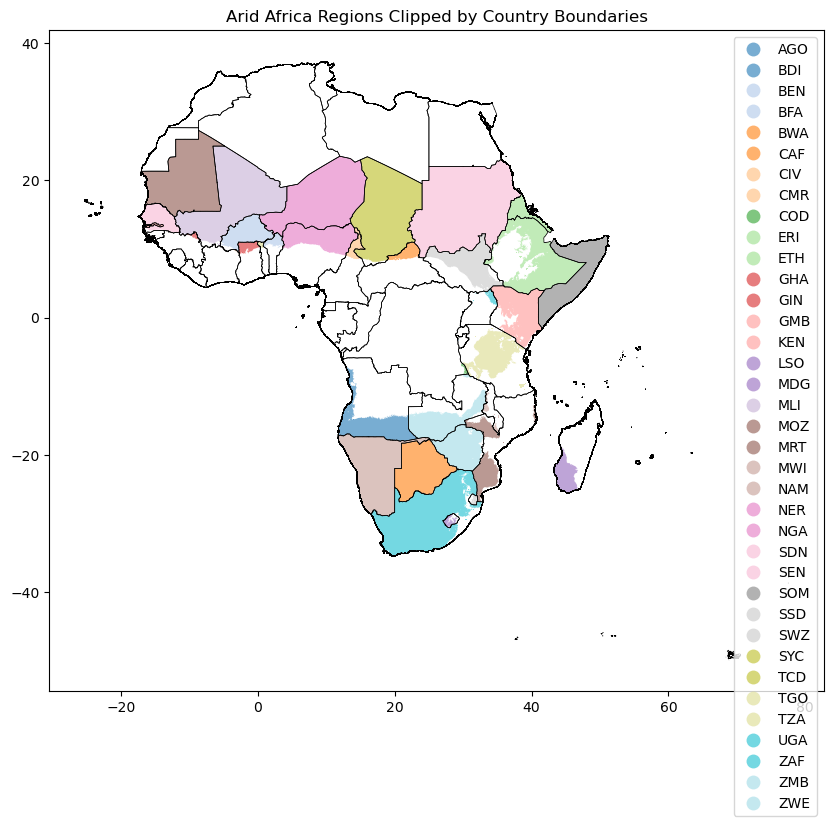

In [8]:
# Load arid regions and Africa boundaries
arid_africa = load_and_reproject(config['Africa_All_shp_path'], target_crs="EPSG:4326")
africa_boundaries = load_and_reproject(config['Africa_boundaries_shp_path'], target_crs="EPSG:4326")

# Clip arid regions by country boundaries
arid_clipped_by_country = gpd.overlay(arid_africa, africa_boundaries, how='intersection')

# Filter to Sub-Saharan Africa using `ssa_iso`
ssa_arid_clipped_by_country = arid_clipped_by_country[arid_clipped_by_country['ISO'].isin(ssa_iso)]

# Save the SSA arid regions shapefile
ssa_output_path = resolve_path(config['SSA_Arid_by_Country_shp_path'])
ssa_arid_clipped_by_country.to_file(ssa_output_path)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
africa_boundaries.boundary.plot(ax=ax, color='black', linewidth=0.5)
ssa_arid_clipped_by_country.plot(ax=ax, column='ISO', cmap='tab20', legend=True, alpha=0.6)
plt.title('Arid Africa Regions Clipped by Country Boundaries')
plt.show()